In [1]:
%matplotlib widget
%matplotlib inline
import torch
import torch.nn as nn
import pickle
import time
import copy
import os
from queue import LifoQueue
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score
from scipy.stats import kurtosis
import matplotlib.pyplot as plt
import numpy as np
import sys
from sklearn.tree import DecisionTreeClassifier
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from tqdm.notebook import tqdm
from sklearn.metrics import pairwise_distances
import network.cpc
from network.cpc import CDCK2
from utils.MatplotlibUtils import reduce_dims_and_plot
from utils.ClassificationUtiols import onehot_coding
from soft_decision_tree.sdt_model import SDT
from sklearn import tree as tt

# IPython.OutputArea.auto_scroll_threshold = 9999;

# Load the model and the dataset

In [2]:
model_path = r'/home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_64/models/epoch_25.pt'
dataset_path = r'/home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_64/data/test_data.file'

print(f"Load the model from: {model_path}")
model = torch.load(model_path, map_location='cpu')

with open(dataset_path, 'rb') as fp:
    dataset = pickle.load(fp)

all_sensors = dataset.dataset.all_signals    
print(f"sensor names: ({len(all_sensors)} total)")

for s in all_sensors:
    print(f"- {s}")
    
print(f"Multihorizon size of the model: {model.timestep}")
print(f"Test split ratio: {len(dataset) / len(dataset.dataset)}")
print(f"Total number of windows in the dataset (without splitting): {len(dataset.dataset)}")

Load the model from: /home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_64/models/epoch_25.pt
sensor names: (18 total)
- speed
- steering_angle
- wheel_speed_0
- wheel_speed_1
- wheel_speed_2
- wheel_speed_3
- accelerometer_0
- accelerometer_1
- accelerometer_2
- gyro_0
- gyro_1
- gyro_2
- gyro_bias_0
- gyro_bias_1
- gyro_bias_2
- gyro_uncalibrated_0
- gyro_uncalibrated_1
- gyro_uncalibrated_2
Multihorizon size of the model: 30
Test split ratio: 0.2
Total number of windows in the dataset (without splitting): 101465


In [3]:
batch_size = 500
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Extract representations

In [4]:
projections = torch.tensor([])
samples = torch.tensor([])
device = 'cuda'
model = model.to(device).eval()

with torch.no_grad():
    bar = tqdm(total=len(loader.dataset))
    for batch in loader:
        hidden = CDCK2.init_hidden(len(batch))
        batch = batch.to(device)
        hidden = hidden.to(device)

        y = model.predict(batch, hidden).detach().cpu()
        projections = torch.cat([projections, y.detach().cpu()])
        samples = torch.cat([samples, batch.detach().cpu()])
        bar.update(y.shape[0])

  0%|          | 0/20293 [00:00<?, ?it/s]

# Fit GMM and calculate indices

In [5]:
scores = []
best_score = float('inf')
clusters = None
range_ = list(range(5, 80))
for k in tqdm(range_):
    y = GaussianMixture(n_components=k).fit_predict(projections)
    cur_score = davies_bouldin_score(projections, y)
    scores.append(cur_score)
    
    if cur_score < best_score:
        best_score = cur_score
        clusters = y

  0%|          | 0/75 [00:00<?, ?it/s]

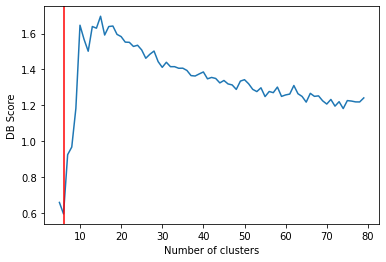

{0, 1, 2, 3, 4, 5}


In [6]:
plt.figure()
plt.xlabel('Number of clusters')
plt.ylabel('DB Score')
plt.plot(range_, scores)
best_k = range_[np.argmin(scores)]
plt.axvline(best_k, color='r')
plt.show()

labels = set(clusters)
print(labels)

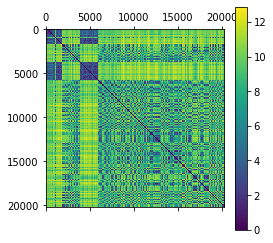

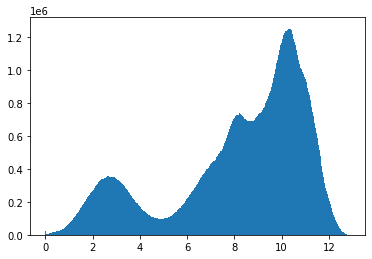

In [7]:
distances = pairwise_distances(projections)
# distances = np.triu(distances)
distances_f = distances.flatten()

plt.matshow(distances)
plt.colorbar()
plt.figure()
plt.hist(distances_f[distances_f > 0], bins=1000)
plt.show()

# Visualize with T-SNE

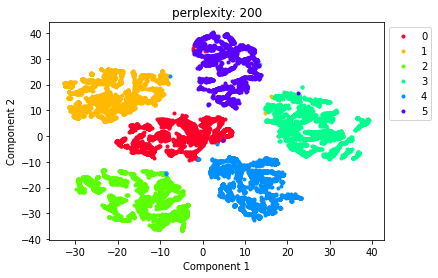

In [8]:
perplexity = 200

p = reduce_dims_and_plot(projections,
                         y=clusters,
                         title=f'perplexity: {perplexity}',
                         file_name=None,
                         perplexity=perplexity,
                         library='Multicore-TSNE',
                         perform_PCA=False,
                         projected=None,
                         figure_type='2d',
                         show_figure=True,
                         close_figure=False,
                         text=None)    

# Train a Soft-Decision-Tree given the self-labels

## Prepare the dataset

In [9]:
# unnormalized_samples = samples.clone()

# for col, sensor in enumerate(tqdm(dataset.dataset.all_signals)):
#     denormalizer = dataset.dataset.get_denormalization_for_sensor(sensor)
#     unnormalized_samples[:, col, :] = denormalizer(unnormalized_samples[:, col, :])

sampled = samples[..., range(0, samples.shape[-1], 200)]

samples_f = sampled.flatten(1)
tree_dataset = list(zip(samples_f, clusters))
batch_size = 2000
tree_loader = torch.utils.data.DataLoader(tree_dataset, batch_size=batch_size, shuffle=True)

# Define how we prune the weights of a node

In [10]:
def prune_node(node_weights, factor=1):
    w = node_weights.cpu().detach().numpy()
    mean_ = np.mean(w)
    std_ = np.std(w)
    node_weights[((mean_ - std_ * factor) < node_weights) & (node_weights < (mean_ + std_ * factor))] = 0
    return node_weights

def prune_node_keep(node_weights, keep=4):
    w = node_weights.cpu().detach().numpy()
    throw_idx = np.argsort(abs(w))[:-keep]
    node_weights[throw_idx] = 0
    return node_weights

def prune_tree(tree_, factor):
    new_weights = tree_.inner_nodes.weight.clone()
    for i in range(new_weights.shape[0]):
        res = prune_node_keep(new_weights[i, :], factor)
        new_weights[i, :] = res

    with torch.no_grad():
        tree_.inner_nodes.weight.copy_(new_weights)
        
def sparseness(x):
    s = []
    for i in range(x.shape[0]):
        x_ = x[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        s.append(sp)
    return np.mean(s)

def compute_regularization_by_level(tree):
    total_reg = 0
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_level = np.floor(np.log2(i+1))
        node_reg = torch.norm(tree.inner_nodes.weight[i].view(-1), 2)
        total_reg += 2**(-cur_level) * node_reg
    return total_reg

def show_sparseness(tree):
    avg_sp = sparseness(tree.inner_nodes.weight)
    print(f"Average sparseness: {avg_sp}")
    layer = 0
    sps = []
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_layer = int(np.floor(np.log2(i+1)))
        if cur_layer != layer:
            print(f"layer {layer}: {np.mean(sps)}")
            sps = []
            layer = cur_layer

        x_ = tree.inner_nodes.weight[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        sps.append(sp)
        
    return avg_sp

## Training configurations

In [11]:
def do_epoch(model, loader, device, log_interval, losses, accs, epoch, iteration):
    model = model.train()
    for batch_idx, (data, target) in enumerate(loader):
        iteration += 1
        data, target = data.to(device), target.to(device)

        output, penalty = tree.forward(data)

        # Loss
        loss_tree = criterion(output, target.view(-1))

        # Penalty
        loss_tree += penalty

        # Sparse regularization
#         fc_params = torch.cat([x.view(-1) for x in tree.inner_nodes.parameters()])
#         regularization = sparsity_lamda * torch.norm(fc_params, 2)
        regularization = sparsity_lamda * compute_regularization_by_level(tree)
        loss = loss_tree

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        pred = output.data.max(1)[1]
        correct = pred.eq(target.view(-1).data).sum()
        accs.append(correct.item() / data.size()[0])

        # Print training status
        if batch_idx % log_interval == 0:
            print(f"Epoch: {epoch:02d} | Batch: {batch_idx:03d} / {len(loader):03d} | Total loss: {loss.item():.3f} | Reg loss: {regularization.item():.3f} | Tree loss: {loss_tree.item():.3f} | Accuracy: {correct.item() / data.size()[0]:03f} | {round((time.time() - start_time) / iteration, 3)} sec/iter")
            
    return iteration


In [12]:
lr = 5e-3
weight_decay = 5e-4
sparsity_lamda = 2e-3
epochs = 500
output_dim = len(set(clusters))
log_interval = 1
tree_depth = 12

In [13]:
tree = SDT(input_dim=samples_f.shape[1], output_dim=len(labels), depth=tree_depth, lamda=1e-3, use_cuda=True)
optimizer = torch.optim.Adam(tree.parameters(),
                                 lr=lr,
                                 weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()
tree = tree.to(device)
clf = DecisionTreeClassifier(max_depth=tree_depth).fit(samples_f, clusters)
print(f"DT accuracy: {clf.score(samples_f, clusters)}")
tree.initialize_from_decision_tree(clf)

DT accuracy: 0.9972897058098852


In [14]:
losses = []
accs = []
sparsity = []

In [ ]:
start_time = time.time()
iteration = 0
for epoch in range(epochs):
    # Training
    avg_sp = show_sparseness(tree)
    sparsity.append(avg_sp)
    iteration = do_epoch(tree, tree_loader, device, log_interval, losses, accs, epoch, iteration)
    
    if epoch % 1 == 0:
        prune_tree(tree, factor=5)
        

Average sparseness: 0.05554543676090637
layer 0: 0.988950276243094
layer 1: 0.988950276243094
layer 2: 0.7417127071823204
layer 3: 0.494475138121547
layer 4: 0.494475138121547
layer 5: 0.46357044198895025
layer 6: 0.3708563535911602
layer 7: 0.2472375690607735
layer 8: 0.15066039364640885
layer 9: 0.06953556629834254
layer 10: 0.035733554903314924
Epoch: 00 | Batch: 000 / 011 | Total loss: 1.789 | Reg loss: 0.019 | Tree loss: 1.789 | Accuracy: 0.194000 | 27.451 sec/iter
Epoch: 00 | Batch: 001 / 011 | Total loss: 1.770 | Reg loss: 0.018 | Tree loss: 1.770 | Accuracy: 0.211000 | 21.05 sec/iter
Epoch: 00 | Batch: 002 / 011 | Total loss: 1.766 | Reg loss: 0.017 | Tree loss: 1.766 | Accuracy: 0.186500 | 18.932 sec/iter
Epoch: 00 | Batch: 003 / 011 | Total loss: 1.749 | Reg loss: 0.017 | Tree loss: 1.749 | Accuracy: 0.337500 | 17.886 sec/iter
Epoch: 00 | Batch: 004 / 011 | Total loss: 1.741 | Reg loss: 0.017 | Tree loss: 1.741 | Accuracy: 0.351000 | 18.663 sec/iter
Epoch: 00 | Batch: 005 / 0

Epoch: 04 | Batch: 008 / 011 | Total loss: 1.640 | Reg loss: 0.014 | Tree loss: 1.640 | Accuracy: 0.581500 | 21.333 sec/iter
Epoch: 04 | Batch: 009 / 011 | Total loss: 1.625 | Reg loss: 0.014 | Tree loss: 1.625 | Accuracy: 0.582500 | 21.349 sec/iter
Epoch: 04 | Batch: 010 / 011 | Total loss: 1.583 | Reg loss: 0.014 | Tree loss: 1.583 | Accuracy: 0.655290 | 21.06 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 05 | Batch: 000 / 011 | Total loss: 1.759 | Reg loss: 0.013 | Tree loss: 1.759 | Accuracy: 0.288000 | 21.471 sec/iter
Epoch: 05 | Batch: 001 / 011 | Total loss: 1.741 | Reg loss: 0.013 | Tree loss: 1.741 | Accuracy: 0.346000 | 21.355 sec/iter
Epoch: 05 | Batch: 002 / 011

Epoch: 09 | Batch: 005 / 011 | Total loss: 1.515 | Reg loss: 0.015 | Tree loss: 1.515 | Accuracy: 0.621000 | 20.661 sec/iter
Epoch: 09 | Batch: 006 / 011 | Total loss: 1.482 | Reg loss: 0.015 | Tree loss: 1.482 | Accuracy: 0.645000 | 20.672 sec/iter
Epoch: 09 | Batch: 007 / 011 | Total loss: 1.471 | Reg loss: 0.015 | Tree loss: 1.471 | Accuracy: 0.634000 | 20.681 sec/iter
Epoch: 09 | Batch: 008 / 011 | Total loss: 1.445 | Reg loss: 0.015 | Tree loss: 1.445 | Accuracy: 0.654500 | 20.649 sec/iter
Epoch: 09 | Batch: 009 / 011 | Total loss: 1.436 | Reg loss: 0.015 | Tree loss: 1.436 | Accuracy: 0.658000 | 20.598 sec/iter
Epoch: 09 | Batch: 010 / 011 | Total loss: 1.428 | Reg loss: 0.016 | Tree loss: 1.428 | Accuracy: 0.641638 | 20.444 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723

Epoch: 14 | Batch: 002 / 011 | Total loss: 1.441 | Reg loss: 0.016 | Tree loss: 1.441 | Accuracy: 0.604500 | 20.195 sec/iter
Epoch: 14 | Batch: 003 / 011 | Total loss: 1.400 | Reg loss: 0.016 | Tree loss: 1.400 | Accuracy: 0.614500 | 20.209 sec/iter
Epoch: 14 | Batch: 004 / 011 | Total loss: 1.354 | Reg loss: 0.016 | Tree loss: 1.354 | Accuracy: 0.634000 | 20.223 sec/iter
Epoch: 14 | Batch: 005 / 011 | Total loss: 1.313 | Reg loss: 0.016 | Tree loss: 1.313 | Accuracy: 0.653500 | 20.236 sec/iter
Epoch: 14 | Batch: 006 / 011 | Total loss: 1.286 | Reg loss: 0.016 | Tree loss: 1.286 | Accuracy: 0.660000 | 20.25 sec/iter
Epoch: 14 | Batch: 007 / 011 | Total loss: 1.247 | Reg loss: 0.016 | Tree loss: 1.247 | Accuracy: 0.676000 | 20.254 sec/iter
Epoch: 14 | Batch: 008 / 011 | Total loss: 1.227 | Reg loss: 0.017 | Tree loss: 1.227 | Accuracy: 0.662000 | 20.229 sec/iter
Epoch: 14 | Batch: 009 / 011 | Total loss: 1.211 | Reg loss: 0.017 | Tree loss: 1.211 | Accuracy: 0.668000 | 20.205 sec/iter
E

layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 19 | Batch: 000 / 011 | Total loss: 1.389 | Reg loss: 0.017 | Tree loss: 1.389 | Accuracy: 0.593000 | 20.804 sec/iter
Epoch: 19 | Batch: 001 / 011 | Total loss: 1.325 | Reg loss: 0.017 | Tree loss: 1.325 | Accuracy: 0.607500 | 20.755 sec/iter
Epoch: 19 | Batch: 002 / 011 | Total loss: 1.265 | Reg loss: 0.017 | Tree loss: 1.265 | Accuracy: 0.612000 | 20.731 sec/iter
Epoch: 19 | Batch: 003 / 011 | Total loss: 1.208 | Reg loss: 0.018 | Tree loss: 1.208 | Accuracy: 0.648000 | 20.737 sec/iter
Epoch: 19 | Batch: 004 / 011 | Total loss: 1.180 | Reg loss: 0.018 | Tree loss: 1.180 | Accuracy: 0.671500 | 20.743 sec/iter
Epoch: 19 | Batch: 005 / 011 | Total loss: 1.131 | Reg loss: 0.018 | Tree loss: 1.131 | Accuracy: 0.676000 | 20.749 sec/iter
Epoch: 19 | Batch: 006 / 011 | Total loss: 1.080 | Reg loss: 0.018 | Tree loss: 1.080 | Accuracy: 0.697000 | 20.755 sec/iter
Epoch: 19 | 

Epoch: 23 | Batch: 010 / 011 | Total loss: 0.860 | Reg loss: 0.019 | Tree loss: 0.860 | Accuracy: 0.778157 | 20.589 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 24 | Batch: 000 / 011 | Total loss: 1.236 | Reg loss: 0.019 | Tree loss: 1.236 | Accuracy: 0.609500 | 20.636 sec/iter
Epoch: 24 | Batch: 001 / 011 | Total loss: 1.173 | Reg loss: 0.019 | Tree loss: 1.173 | Accuracy: 0.644500 | 20.643 sec/iter
Epoch: 24 | Batch: 002 / 011 | Total loss: 1.133 | Reg loss: 0.019 | Tree loss: 1.133 | Accuracy: 0.667500 | 20.649 sec/iter
Epoch: 24 | Batch: 003 / 011 | Total loss: 1.078 | Reg loss: 0.019 | Tree loss: 1.078 | Accuracy: 0.708000 | 20.655 sec/iter
Epoch: 24 | Batch: 004 / 01

Epoch: 28 | Batch: 007 / 011 | Total loss: 0.841 | Reg loss: 0.020 | Tree loss: 0.841 | Accuracy: 0.748500 | 20.435 sec/iter
Epoch: 28 | Batch: 008 / 011 | Total loss: 0.805 | Reg loss: 0.020 | Tree loss: 0.805 | Accuracy: 0.781500 | 20.441 sec/iter
Epoch: 28 | Batch: 009 / 011 | Total loss: 0.789 | Reg loss: 0.020 | Tree loss: 0.789 | Accuracy: 0.776500 | 20.435 sec/iter
Epoch: 28 | Batch: 010 / 011 | Total loss: 0.798 | Reg loss: 0.020 | Tree loss: 0.798 | Accuracy: 0.757679 | 20.385 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 29 | Batch: 000 / 011 | Total loss: 1.147 | Reg loss: 0.020 | Tree loss: 1.147 | Accuracy: 0.599500 | 20.456 sec/iter
Epoch: 29 | Batch: 001 / 01

In [ ]:
plt.figure(figsize=(10, 5))
plt.ylabel("Accuracy")
plt.xlabel('Iteration')
plt.plot(accs, label='Accuracy vs iteration')
plt.show()

In [ ]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel('Iteration')
plt.plot(losses, label='Loss vs iteration')
plt.yscale("log")
plt.show()

plt.figure()
weights = tree.inner_nodes.weight.cpu().detach().numpy().flatten()
plt.hist(weights, bins=500)
weights_std = np.std(weights)
weights_mean = np.mean(weights)
plt.axvline(weights_mean + weights_std, color='r')
plt.axvline(weights_mean - weights_std, color='r')
plt.title(f"Mean: {weights_mean}   |   STD: {weights_std}")
plt.yscale("log")
plt.show()

# Tree Visualization

In [ ]:
plt.figure(figsize=(15, 10), dpi=80)
avg_height, root = tree.visualize()

# Extract Rules

# Accumulate samples in the leaves

In [ ]:
print(f"Number of patterns: {len(root.get_leaves())}")

In [ ]:
method = 'MLE'

In [ ]:
root.clear_leaves_samples()

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tree_loader):
        root.accumulate_samples(data, method)

# Tighten boundaries

In [ ]:
signal_names = dataset.dataset.all_signals
normalizers = torch.tensor([])
attr_names = []
for signal_name in signal_names:
    attr_names += [f"T{i}.{signal_name}" for i in range(sampled.shape[-1])]
    sensor_norm = torch.tensor([torch.tensor(dataset.dataset.sensor_maxs[signal_name]) for _ in range(sampled.shape[-1])])
    normalizers = torch.cat([normalizers, sensor_norm])
    

# print(attr_names)
leaves = root.get_leaves()
sum_comprehensibility = 0
comprehensibilities = []
for pattern_counter, leaf in enumerate(leaves):
    leaf.reset_path()
    leaf.tighten_with_accumulated_samples()
    conds = leaf.get_path_conditions(attr_names)
    for cond in conds:
        cond.weights = cond.weights / normalizers
    print(f"============== Pattern {pattern_counter + 1} ==============")
    comprehensibilities.append(sum([cond.comprehensibility for cond in conds]))
    
print(f"Average comprehensibility: {np.mean(comprehensibilities)}")
print(f"std comprehensibility: {np.std(comprehensibilities)}")
print(f"var comprehensibility: {np.var(comprehensibilities)}")
print(f"minimum comprehensibility: {np.min(comprehensibilities)}")
print(f"maximum comprehensibility: {np.max(comprehensibilities)}")